# Spam Filter using Naive Bayes Classifier

**Import libraries**

In [5]:
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Read csv file**

In [7]:
df = pd.read_csv('ham or spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Describe dataset and visualize ham/spam count**

In [8]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

<AxesSubplot:xlabel='label', ylabel='count'>

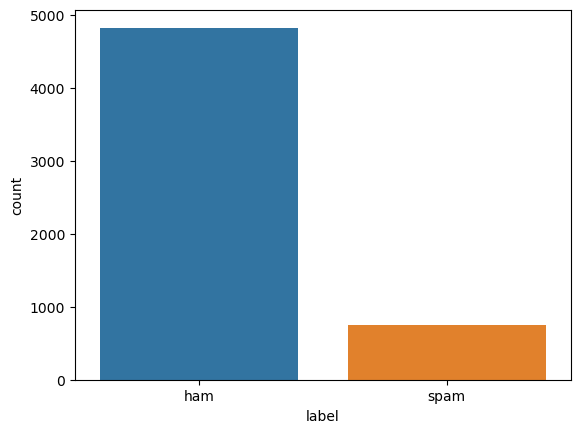

In [9]:
sns.countplot(data=df, x='label')

** Lets move directly to creating spam filter <br>
Our approach:
**
1. Clean and Normalize text
2. Convert text into vectors (using bag of words model) that machine learning models can understand
3. Train and test Classifier

**Clean and normalize text**<br>
It will be done in following steps:<br>
1. Remove punctuations
2. Remove all stopwords
3. Apply [stemming](https://en.wikipedia.org/wiki/Stemming) (converting to normal form of word). <br>
   For example, 'driving car' and 'drives car' becomes drive car<br>

** Write a method to return normailzed text in form of tokens (lemmas)**

In [10]:
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer
def process(text):
    # lowercase it
    text = text.lower()
    # remove punctuation
    text = ''.join([t for t in text if t not in string.punctuation])
    # remove stopwords
    text = [t for t in text.split() if t not in stopwords.words('english')]
    # stemming
    st = Stemmer()
    text = [st.stem(t) for t in text]
    # return token list
    return text

In [11]:
# Testing
process('It\'s holiday and we are playing cricket. Jeff is playing very well!!!')

['holiday', 'play', 'cricket', 'jeff', 'play', 'well']

In [12]:
# Test with our dataset
df['message'][:20].apply(process)

0     [go, jurong, point, crazi, avail, bugi, n, gre...
1                          [ok, lar, joke, wif, u, oni]
2     [free, entri, 2, wkli, comp, win, fa, cup, fin...
3         [u, dun, say, earli, hor, u, c, alreadi, say]
4     [nah, dont, think, goe, usf, live, around, tho...
5     [freemsg, hey, darl, 3, week, word, back, id, ...
6     [even, brother, like, speak, treat, like, aid,...
7     [per, request, mell, mell, oru, minnaminungint...
8     [winner, valu, network, custom, select, receiv...
9     [mobil, 11, month, u, r, entitl, updat, latest...
10    [im, gonna, home, soon, dont, want, talk, stuf...
11    [six, chanc, win, cash, 100, 20000, pound, txt...
12    [urgent, 1, week, free, membership, å£100000, ...
13    [ive, search, right, word, thank, breather, pr...
14                                       [date, sunday]
15    [xxxmobilemovieclub, use, credit, click, wap, ...
16                                     [oh, kim, watch]
17    [eh, u, rememb, 2, spell, name, ye, v, nau

**Convert each message to vectors that machine learning models can understand.<br>We will do that using bag-of-words model**
<br>We will use TfidfVectorizer. It will convert collection of text documents (SMS corpus) into 2D matrix.
<br>One dimension represent documents and other dimension repesents each unique word in SMS corpus .
.
<br>If **n<sup>th</sup> term t has occured p times in m<sup>th</sup> document**, (m, n) value in this matrix will be TF-IDF(t), <br><center>where [TF-IDF(t)](https://en.wikipedia.org/wiki/Tf–idf) = Term Frequency (TF) * Inverse Document Frequency (IDF)</center>
<br>Term Frequency (TF) is a measure of how frequent a term occurs in a document.<br>
<br><center>TF(t)= Number of times term t appears in document (p) / Total number of terms in that document</center>
<br>Inverse Document Frequency (IDF) is measure of how important term is. For TF, all terms are equally treated. But, in IDF, for words that occur frequently like 'is' 'the' 'of' are assigned less weight. While terms that occur rarely that can easily help identify class of input features will be weighted high.<br>
<br><center>Inverse Document Frequency, IDF(t)= log<sub><i>e</i></sub>(Total number of documents / Number of documents with term t in it)</center>
<br>At end we will have for every message, vectors normalized to unit length equal to size of vocalbulary (number of unique terms from entire SMS corpus)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

**Fit and transform SMS corpus**

In [14]:
tfidfv = CountVectorizer()
data = tfidfv.fit_transform(df['message'])

**Lets check what values it gives for a message**

In [15]:
mess = df.iloc[2]['message']
print(mess)

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [16]:
print(tfidfv.transform([mess]))

  (0, 77)	1
  (0, 402)	1
  (0, 411)	1
  (0, 784)	1
  (0, 1156)	1
  (0, 2165)	1
  (0, 2386)	1
  (0, 2949)	2
  (0, 3087)	2
  (0, 3207)	1
  (0, 3358)	1
  (0, 4087)	1
  (0, 4930)	1
  (0, 6190)	1
  (0, 6242)	1
  (0, 6297)	1
  (0, 7230)	1
  (0, 7595)	1
  (0, 7743)	1
  (0, 7756)	3
  (0, 7933)	1
  (0, 8405)	1
  (0, 8447)	1


**Having messages in form of vectors, we are ready to train our classifier. <br>We will use Naive Bayes which is well known classifier while working with text data. 
<br>Before that we will use pipeline feature of sklearn to create a pipeline of Vectorizer followed by Classifier.**
<br>Input will be message passed to first stage Vectorizer which will transform it and pass it to Naive Bayes Classifier to get output label

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
spam_filter = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=process)), # messages to weighted TFIDF score
    ('classifier', MultinomialNB())                    # train on TFIDF vectors with Naive Bayes
])

**Perform train test split**

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.20, random_state = 21)

**Train spam_filter**

In [22]:
spam_filter.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function process at 0x7f34d377f8b0>)),
                ('classifier', MultinomialNB())])

**Predict for test cases**

In [23]:
predictions = spam_filter.predict(x_test)

In [24]:
count = 0
for i in range(len(y_test)):
    if y_test.iloc[i] != predictions[i]:
        count += 1
print('Total number of test cases', len(y_test))
print('Number of wrong of predictions', count)

Total number of test cases 1115
Number of wrong of predictions 19


**Check for wrong predictions that were classified as ham**

In [25]:
x_test[y_test != predictions]

693     Will purchase d stuff today and mail to you. D...
3417    LIFE has never been this much fun and great un...
3358    Sorry I missed your call let's talk when you h...
3862    Oh my god! I've found your number again! I'm s...
5475    Dhoni have luck to win some big title.so we wi...
1268    Can U get 2 phone NOW? I wanna chat 2 set up m...
395     From here after The performance award is calcu...
2246    Hi ya babe x u 4goten bout me?' scammers getti...
3528    Xmas & New Years Eve tickets are now on sale f...
4142    In The Simpsons Movie released in July 2007 na...
3979                                   ringtoneking 84484
1637    0A$NETWORKS allow companies to bill for SMS, s...
4701                                           Anytime...
3413                              No pic. Please re-send.
4417                           When you get free, call me
760     Romantic Paris. 2 nights, 2 flights from å£79 ...
1892    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
2967          

**Use classification report to get more details**

In [26]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       978
        spam       0.92      0.94      0.93       137

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Looking at precision column (for ham, it is 1.00), we can say that all number of wrong predictions (in output of [18]) came from spam predicted as ham. It is ok and cost of predicting spam as ham is negligible to that of predicting ham as spam.

Function to predict whether passed message is ham or spam

In [27]:
def detect_spam(s):
    return spam_filter.predict([s])[0]
detect_spam('Your cash-balance is currently 500 pounds - to maximize your cash-in now, send COLLECT to 83600.')

'spam'